# CatBoost Model for Ethereum Fraud Detection
# This notebook implements the **CatBoost (Categorical Boosting)** algorithm.
# CatBoost is a high-performance gradient boosting library known for:
# 1. Being extremely fast and efficient.
# 2. Handling data patterns very well with less need for hyperparameter tuning.
# 3. Often outperforming XGBoost and LightGBM on tabular data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score, classification_report)
from catboost import CatBoostClassifier

# 2. LOAD DATA
# We use the Time-Series version of the dataset as it contains the richest features.

In [3]:
file_path = '../Data/address_data_combined_ts.csv'
df = pd.read_csv(file_path)

print(f"Data Loaded. Shape: {df.shape}")
df.head()

Data Loaded. Shape: (13920, 24)


,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,...,adjusted_eth_value__absolute_sum_of_changes,adjusted_eth_value__mean_abs_change,adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,adjusted_eth_value__sum_values,adjusted_eth_value__abs_energy,adjusted_eth_value__ratio_value_number_to_time_series_length,adjusted_eth_value__quantile__q_0.1,adjusted_eth_value__count_below__t_0,adjusted_eth_value__count_above__t_0,adjusted_eth_value__median
0,0x87d884aaa6ff9e9b6014631b0abae80b53953fb8,1,5151.68,15159.08,71235.62,1,0.010000,0.020000,0.013367,0.000000,...,0.129900,0.008119,0.358576,0.032100,0.001400,0.470588,-0.000000,0.647059,0.941176,0.000
1,0xd42393df90d582bd8a5493171f0173e3a017d391,1,1179.02,1124.89,25126.45,13,0.000000,0.750000,0.176667,0.145000,...,7.669778,0.365228,0.020237,-0.284889,3.335466,0.409091,-0.267421,0.363636,0.681818,0.150
2,0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37,1,361.73,0.00,723.47,1,4.999916,4.999916,4.999916,2.490000,...,7.508992,3.754496,0.666738,0.000840,37.494722,1.000000,-2.505261,0.666667,0.333333,-2.490
3,0x6309f709faad518fc158af4c14edfa7b06424770,1,0.00,0.00,0.00,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
4,0x3d020954e30c3d40b7f0c533cf198bc10dd45a49,1,14280.60,1479.86,45357.57,21,0.035000,0.200000,0.099286,2.084658,...,3.404658,0.162127,0.006660,0.000342,4.594823,0.409091,0.050000,0.045455,0.954545,0.085


# 3. DATA PREPROCESSING

# Define X (features) and y (target)
# We drop 'Address' (ID), 'FLAG' (Target), and 'Unnamed: 0' if it exists.

In [4]:
cols_to_drop = ['Address', 'FLAG']
if 'Unnamed: 0' in df.columns:
    cols_to_drop.append('Unnamed: 0')

X = df.drop(columns=cols_to_drop)
y = df['FLAG']

# Split Data (70% Train, 30% Test) - Matching the other models' split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (9744, 22)
Testing Shape: (4176, 22)


# 4. FEATURE ENGINEERING (Log Transform)
# We apply log transformation to skewed columns to help the model learn better.
# This matches the logic used in the XGBoost and LightGBM notebooks.

In [5]:
columns_to_log = [
    'Avg min between sent tnx', 'Avg min between received tnx',
    'Time Diff between first and last (Mins)', 'Unique Received From Addresses',
    'min value received', 'max value received ', 'avg val received',
    'min val sent', 'avg val sent',
    'total transactions (including tnx to create contract',
    'total ether received', 'total ether balance',
    'adjusted_eth_value__absolute_sum_of_changes',
    'adjusted_eth_value__mean_abs_change',
    'adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0',
    'adjusted_eth_value__sum_values', 'adjusted_eth_value__abs_energy',
    'adjusted_eth_value__ratio_value_number_to_time_series_length',
    'adjusted_eth_value__quantile__q_0.1', 'adjusted_eth_value__count_below__t_0',
    'adjusted_eth_value__count_above__t_0', 'adjusted_eth_value__median'
]

# Apply Log Transform (handling zeros safely)

In [6]:
for c in columns_to_log:
    if c in X_train.columns:
        X_train[c] = X_train[c].apply(lambda x: np.log(x) if x > 0 else 0)
        X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# 5. SCALING
# We use MinMaxScaler to squash values between 0 and 1.

In [7]:
scaler = MinMaxScaler()

# Fit on training data, transform both

In [8]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. MODEL DEFINITION & TRAINING
# We initialize CatBoost with parameters similar to the other high-performing models.
# verbose=0 keeps the output clean (suppresses the training log).

In [9]:
cat_model = CatBoostClassifier(
    iterations=1000,         # Number of trees (similar to n_estimators)
    learning_rate=0.05,      # Step size
    depth=6,                 # Depth of trees
    l2_leaf_reg=3,           # Regularization to prevent overfitting
    loss_function='Logloss', # Binary Classification objective
    eval_metric='AUC',       # Optimize for AUC
    random_seed=42,
    verbose=0                # Set to True if you want to see training progress
)

print("Training CatBoost Model...")
cat_model.fit(X_train_scaled, y_train)
print("✅ Training Complete.")

Training CatBoost Model...
✅ Training Complete.


# 7. EVALUATION
# Make predictions

In [10]:
y_pred = cat_model.predict(X_test_scaled)
y_pred_proba = cat_model.predict_proba(X_test_scaled)[:, 1]

# Calculate Metrics

In [11]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 8. CONFUSION MATRIX VISUALIZATION

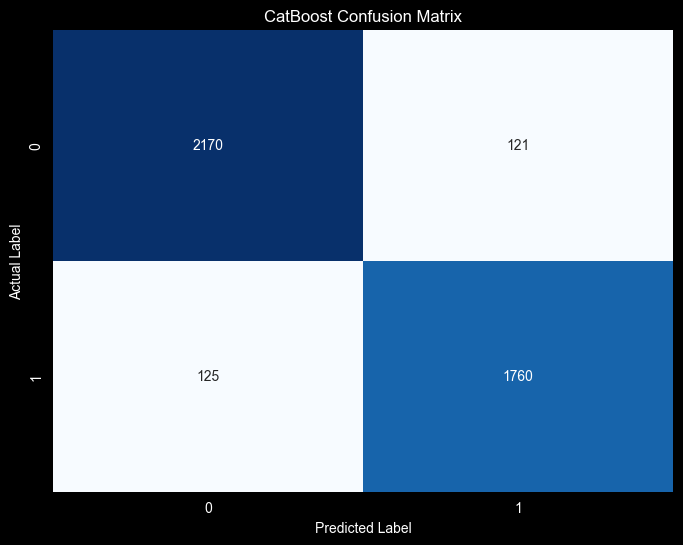

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('CatBoost Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Create dataframe for plotting

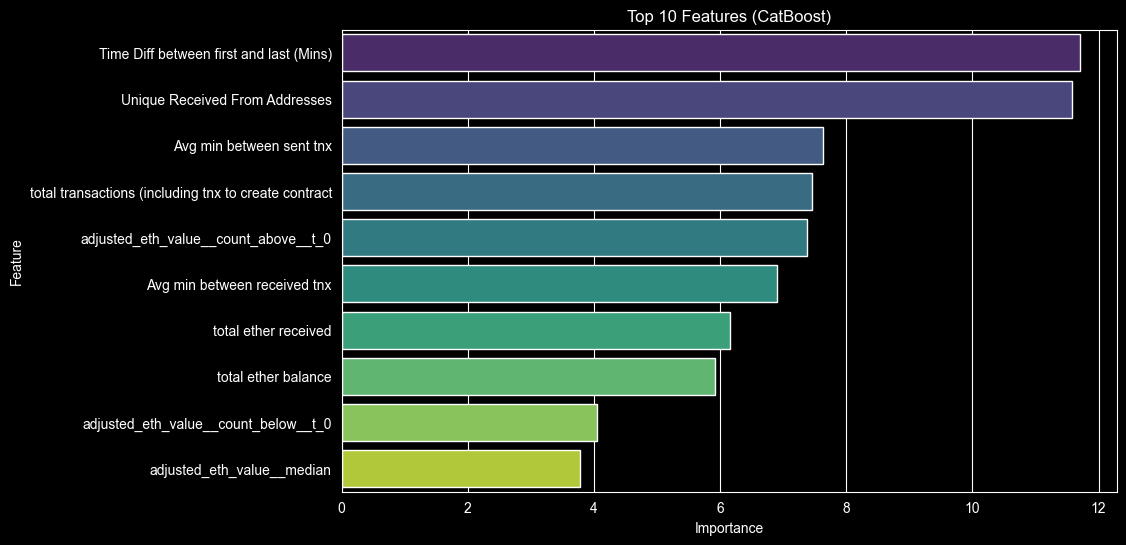

In [15]:
plt.figure(figsize=(10, 6))

# FIXED LINE: Added hue='Feature' and legend=False
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',     # <--- New: tells seaborn what to color by
    data=fi_df,
    palette='viridis',
    legend=False       # <--- New: hides the redundant legend
)

plt.title('Top 10 Features (CatBoost)')
plt.show()